# Data Exploration (Part VIII - Datashader Deep Dive)
## Review
Last post, we looked at
1. Loading a parquet
2. Installing datashader
3. Using datashader

We ran into enough issues to make a post out of those items.

### Parquet
On the parquet side, I became familiar with the parquet file format and the partitioned nature of data storage within distributed computing platforms (in this case, I used Spark). I saw that the fastparquet library allowed me to read in partitioned .parquet files in aggregate, and convert that to a single Pandas dataframe. I decided to stray away from Spark and venture into single-node Python / Pandas because I couldn't find any visualization packages within the Spark ecosystem, and only looking at lat / longs didn't actually require much memory or compute power because we could throw away the rest of the data.

### Installing Datashader
I didn't go into too much detail here last post, I kinda just did it, but I think the following code requires a bit of explaining at least.

In [1]:
# Install datashader via conda, we use the -y flag so we don't have to reply to any prompts
import os
os.system("sudo /home/ec2-user/src/anaconda2/bin/conda install -y bokeh datashader")
os.system("sudo /home/ec2-user/src/anaconda2/bin/conda remove --force datashader")
os.system("git clone https://github.com/bokeh/datashader.git")
os.system("sudo pip install -e datashader/")
os.system("sudo pip install dask[complete]")

0

Man, what's happening here, exactly? First of all, I had to understand the difference between _**conda**_ and _**pip**_. The first thing I thought to do was

~~~~
sudo pip install datashader
~~~~

Seems reasonable, right? After all, this is what we've been doing so far within our other projects and posts. The probem is that datashader (being relatively new) is not yet on the pypi repository which pip points to. From my understanding, this takes a bit of work for the datashader folks because datashader relies on packages which _**are not purely python**_. In comes _**conda**_.

The difference between pip and conda is that pip _**only manages python-related packages**_, while conda is not restricted like this. When we download the Anaconda distribution of python, we aren't only getting python, we get a slew of other tools like R and Jupyter. These tools are not python-centric obviously, with R being a completely separate language and environment altogether. Datashader apparently requires packages which are not in the python environment specifically, so the only way to install datashader currently is to do it through conda.

But wait, it gets more complicated...

<img src="https://68.media.tumblr.com/3edaa84c20e78e011a718a95b1de1338/tumblr_nl7gi0ogM51sy9yybo1_500.gif" width="300">

Why does it look like I install datashader with conda, and then... remove it? This is where AWS and my lack of knowledge comes in. When I tried to install datashader using conda, I had to specify the conda at the path

> _**/home/ec2-user/src/anaconda2/bin/conda**_

Note that there exists an _**anaconda3**_ folder as well because the [Amazon Deep Learning AMI](https://aws.amazon.com/marketplace/pp/B01M0AXXQB) comes with both the python 2 and python 3 versions of the Anaconda distribution, with Jupyter connected to both.

![](https://s3.ca-central-1.amazonaws.com/2017edmfasatb/nypd_complaints/images/32_jupyter_multiple_kernel.png)

Just like there is a _**pip**_ for python 2 and _**pip3**_ for python 3, there exists multiple conda prompts for each environment. When I tried to used the python 2 conda to install datashader, my python 2 environment wouldn't recognize the package. It kept saying datashader module is not found. Datashader provides instructions on how to [install from source with pip](https://github.com/bokeh/datashader), so I did that instead. I had to install an additional library as well (_**dask[complete]**_) to make datashader work once and for all. Hope this all makes sense, and is not too convoluted!

![](https://i.giphy.com/media/Vg0JstydL8HCg/giphy.webp)

## Datashader Deep Dive
Let's continue with our datashader deep dive. I will pretty much be following [this datashader notebook on US census data](https://anaconda.org/jbednar/census/notebook) because it is exactly what I want to do.

### Load Data
Let's load the data again using fastparquet.

In [2]:
import os
os.system("sudo pip install fastparquet s3fs python-snappy")

0

In [3]:
import s3fs
import fastparquet as fp
s3 = s3fs.S3FileSystem()
fs = s3fs.core.S3FileSystem()

# Set up s3fs path object
s3_path = "2017edmfasatb/nypd_complaints/data/df_filtered.parquet/*.parquet"
all_paths_from_s3 = fs.glob(path = s3_path)

# Load file from S3
myopen = s3.open

# Use s3fs as the filesystem
fp_obj = fp.ParquetFile(all_paths_from_s3, open_with = myopen)

In [4]:
%%time
# Load only lat and long to pandas dataframe
df = fp_obj.to_pandas(['LAT', 'LON'])

CPU times: user 2.75 s, sys: 76 ms, total: 2.82 s
Wall time: 4.92 s


In [5]:
# View dataframe
df.head()

,LAT,LON
0,40.828848,-73.916661
1,40.697338,-73.784557
2,40.802607,-73.945052
3,40.654549,-73.726339
4,40.738002,-73.987891


### Plot Only Lat Long
The tutorial goes through a few initial library loads and configurations to make the background color black. Datashader states that

> _**A black background makes bright colors more vivid**_

I'll believe em because their census maps look breathtaking.

In [2]:
# Load general libraries
import numpy as np
import pandas as pd

# Load datashader / visualization related libraries
import datashader as ds
import datashader.transfer_functions as tf
from functools import partial
from datashader.utils import export_image
from datashader.colors import colormap_select, Greys9
from colorcet import fire
from IPython.core.display import HTML, display

# Initial datashader / visualization configuration
background = 'black'
export = partial(export_image, background = background, export_path="export")
cm = partial(colormap_select, reverse=(background!="black"))

Let's plot the lat long.

In [6]:
%%time
# Initiate canvas and create grid
cvs = ds.Canvas()
agg = cvs.points(df, 'LON', 'LAT')

CPU times: user 576 ms, sys: 8 ms, total: 584 ms
Wall time: 566 ms


According to datashader, what we've done above is convert our actual points into a aggregated grid per pixel. In this step, every data point is iterated through and visualizations going forward will depend on this grid. Apparently visualizations using this grid should be instantaneous because there are far fewer pixels than actual data points.

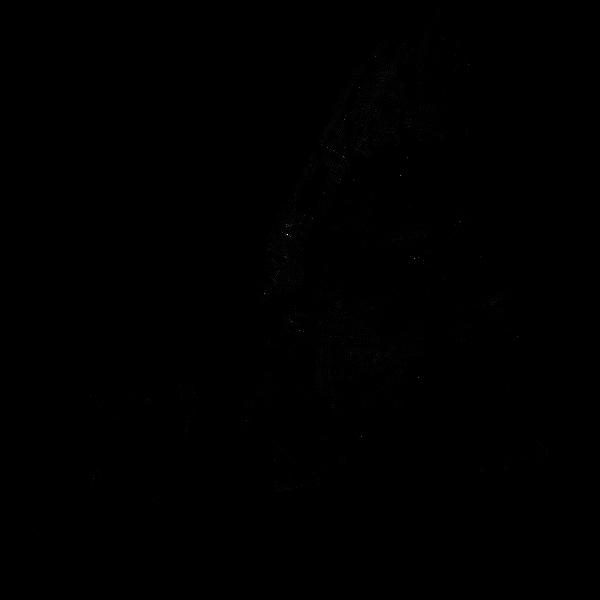

In [11]:
# Show map with linear gradient
export(tf.shade(agg, cmap = cm(Greys9), how = 'linear'), 'export')

Similar to to the census tutorial... we get almost nothing with some bright spots that I can't even make out the location. What we're seeing here is [_**undersampling**_](https://anaconda.org/jbednar/plotting_pitfalls/notebook). Unfortunately the densities every where else other than the bright spots are _**so close to 0 relative to the peaks**_ that it looks like there is no data there.

The next thing the census tutorial does it put a _**floor**_ of 20% of the full, saturated value. Let's say the range of values that any pixel can take is $[0, 1]$, with $0$ being completely black (same as background) and $1$ being completely white (or grey, in the case of this color gradient we're currently using). Putting a floor of 20% of the full value means that, now, the gradient will range from $[0.20, 1]$. This should prevent undersampling by forcing low values to take on some type of color.

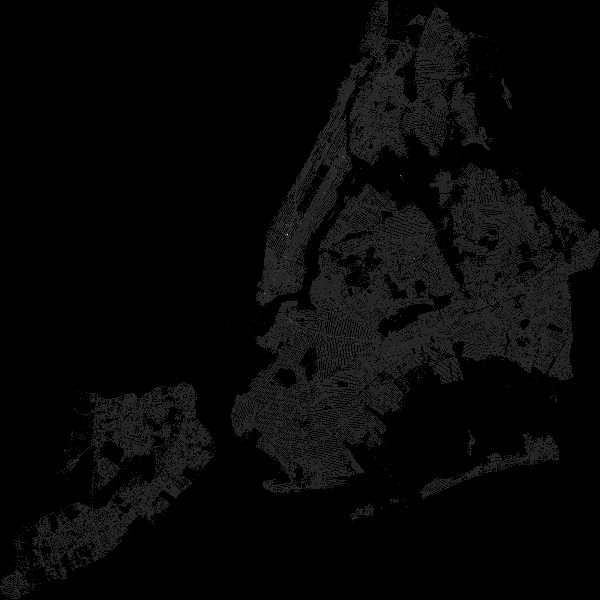

In [14]:
# Show map with floor of 0.25
export(tf.shade(agg, cmap = cm(Greys9, 0.20), how = 'linear'), "export")

Sure enough, we do see some type of NYC structure appearing. We can even start to make out where the hot spots are! There seems to be a large hotpot just south of Central Park. This map is more useful, but still has a lot of usefulness left to be extracted from it! As the tutorial states:

> _**The problem is that of the available intensity scale in this gray colormap, nearly all pixels are colored the same low-end gray value, with only a few urban areas using any other colors. Thus this version of the map conveys very little information as well. Because the data are clearly distributed so non-uniformly, let's instead try a nonlinear mapping from population counts into the colormap. A logarithmic mapping is often a good choice.**_

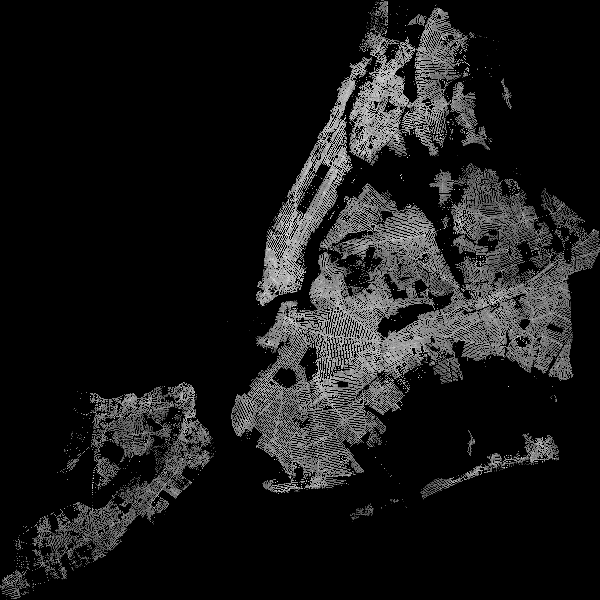

In [26]:
# Show map with log gradient
export(tf.shade(agg, cmap = cm(Greys9, 0.2), how = 'log'), "export")

More structure appears, but it still looks quite unifrom. We for sure see the amount of crime in Manhattan and the Bronx vs an area like Staten Island, but we've kind of lost track of the hot spots now. Manhattan kind of looks like one big hot spot...

Again, datashader provides a nice insight:

> _**Worryingly, though, the choice of 'log' was purely arbitrary, basically just a hunch based on how many datasets behave. One could easily imagine that other nonlinear functions would show other interesting patterns, or that different functions would be needed for different datasets.**_

Datashader then suggests using a image processing method called _**histogram equalization**_:

> _**With this idea of showing relative differences across a large range of data values in mind, let's try the image-processing technique called histogram equalization. I.e., given a set of raw counts, map these into a range for display such that every available color on the screen represents about the same number of samples in the original dataset. The result is similar to that from the log transform, but is now non-parametric -- it will equalize any linearly or nonlinearly distributed integer data, regardless of the distribution:**_

Let's give it a go.

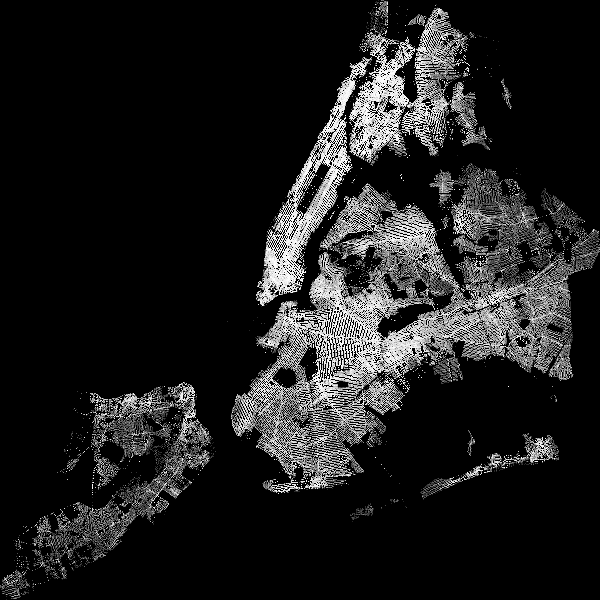

In [31]:
# Show map with log gradient
export(tf.shade(agg, cmap = cm(Greys9, 0.2), how = 'eq_hist'), "export")

A bit more contrast here. Nice. Parts of Manhattan and Bronx are starting to show _**very**_ bright spots. Datashader shows the capabilities of using _**other**_ color maps as well which may have more dynamic range:

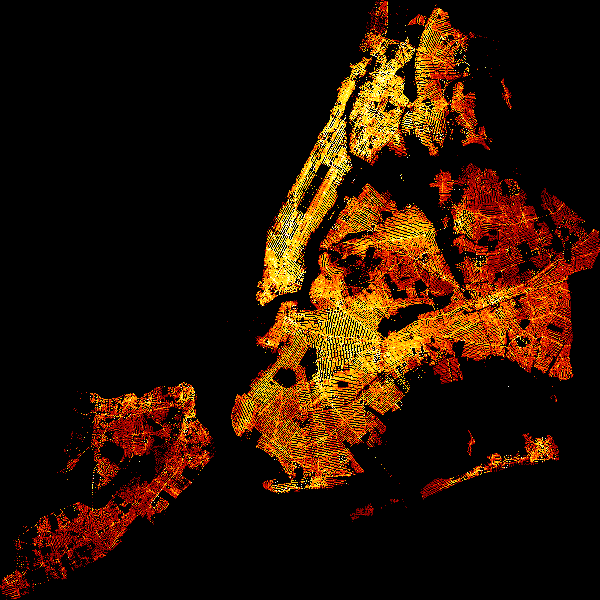

In [32]:
# Show map with 'fire' color map
export(tf.shade(agg, cmap = cm(fire, 0.2), how = 'eq_hist'), "export")

Oh man, that's looking _**really**_ good. Datashader itself has color maps too.

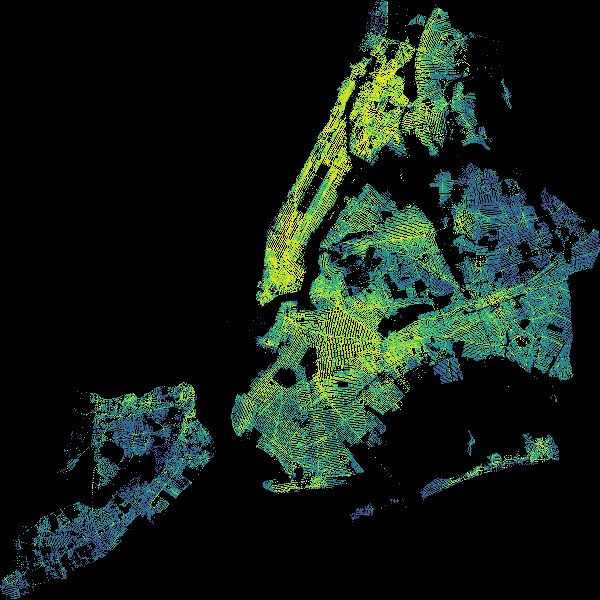

In [38]:
from datashader.colors import viridis

# Show map with 'viridis' color map
export(tf.shade(agg, cmap = cm(viridis, 0.2), how = 'eq_hist'), "export")

Because we're using a histogram equalization method at this point, I'm actually not so sure we need that 0.2 floor anymore... let's try it without.

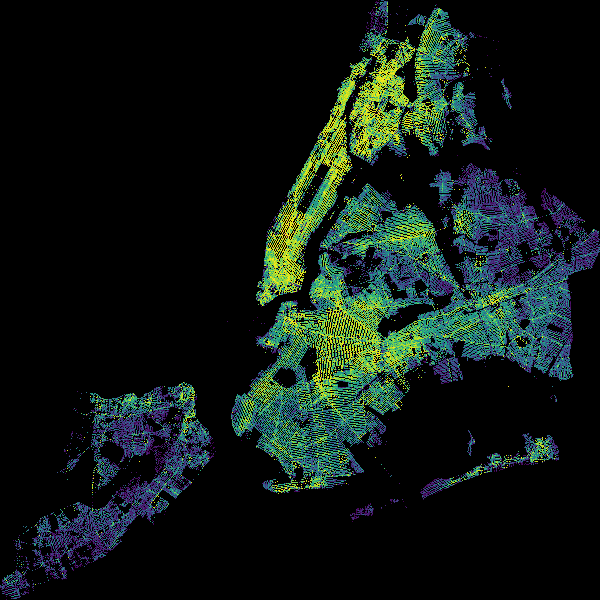

In [39]:
# Show map with 'viridis' color map with no floor
export(tf.shade(agg, cmap = cm(viridis), how = 'eq_hist'), "export")

![](https://img.ifcdn.com/images/5845f34942d0c4bc73a01c1fe1565607a6012d89a6142066cc0e4fa410630e98_1.gif)

The last thing the census tutorial does before getting into categorical data is highlight the top 1% of population density areas. We can do the same thing here, showing top 1% of areas with offenses by highlighting them red.

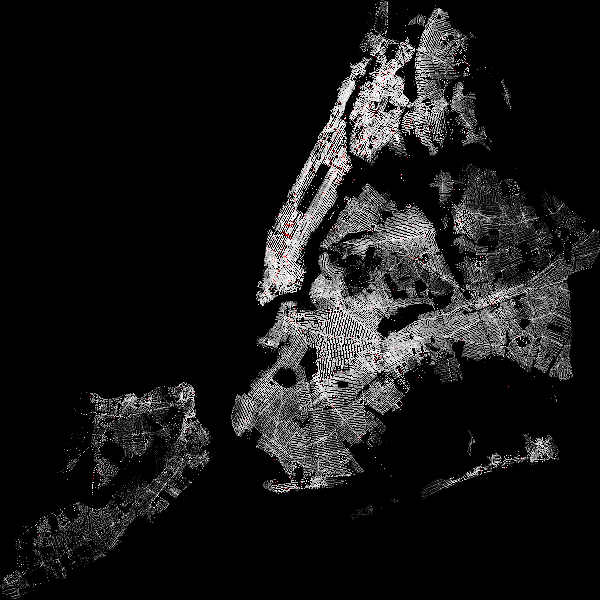

In [42]:
# Show map with top 1% of offense density areas shaded red
grays2 = cm([(i,i,i) for i in np.linspace(0,255,99)])
grays2 += ['red']
export(tf.shade(agg, cmap = grays2, how = 'eq_hist'), "export")

This is interesting how datashader does this. Since we are using histogram equalization, we're forcing _**every possible value in the color map to take on an equal amount of data samples**_. Above, we created a color gradient with _**100 possible colors**_. We've forced the black to white gradient ($[0, 255]$) onto the first 99 elements of the final color gradient, and we add the color red to the 100th element of the color gradient. In essence, the first 99% of the data will be represented by the black to white gradient, and last 1% of data will be represented by red.

Let's see what happens with the top 5%.

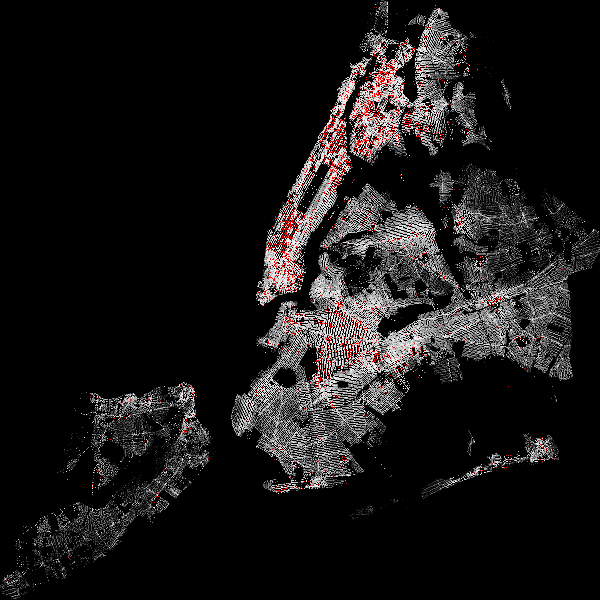

In [43]:
# Show map with top 5% of offense density areas shaded red
grays2 = cm([(i,i,i) for i in np.linspace(0,255,94)])
grays2 += ['red', 'red', 'red', 'red', 'red']
export(tf.shade(agg, cmap = grays2, how = 'eq_hist'), "export")

It becomes so clear where highly dense crime areas are! Manhattan takes the cake for sure, and the Bronx is not too far behind. We see quite a bit in Brooklyn as well, but not as much. We have random pockets here and there, which may be attributed to certain neighbourhoods or landmarks.

That's probably enough for this post. Let's dive into categorical mapping in the next post.